This notebook will develop a function to read wideband frequency response output from Echoview and adjust the frequency bins to resample at a given frequency range points.

In [16]:
import csv
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import array as arr
%matplotlib inline

In [17]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)

# Write function to read file

In [34]:
def read_scatteringmodelsimulations(fname, nsim, ve=False):
    """"Opens a file created by R for ZooScatR containing all the information of the model runs. 
    Extract the frequencies, species and cross-sectional backscatter data.
    
    Parameters:
    fname: filename with path of EV export from wideband frequency response plot - graph- export
    nsim: number of simulations

    
    Returns:
    spec: array of name of species
    freqs: array of frequencies
    sigma_bs: array of cross-sectional backscatter simulation values shape is [frequencies, simulations, species]
    """
    simulations = pd.read_feather(fname)
    # Add a row for sigma_bs calculated from TS
    simulations['sigbs'] = 10**(simulations.TS/10)
    
    # Set dimensions and their values
    freqs = simulations['freq'].unique()
    specs = simulations['spec'].unique()
    
    # Allocate space
    sigma_bs_all = np.zeros([len(freqs), nsim, len(specs)])
    sigma_bs_mean = np.zeros([len(freqs), len(specs)])
    #Sort values in sibgs column by species and frequencies
    simulations_group = simulations.groupby(["spec","freq"]).agg({'sigbs':lambda x: arr.array('d', x)})
    
    #for mean output
    simulations_mean = simulations.groupby(["spec","freq"]).agg({'sigbs':'mean'})
    mean_bs = simulations_mean.reset_index('freq')

    #Manually organize into an array
    for ind_spec in range(0, len(specs)):
        spec_name = specs[ind_spec]
        sim_spec = np.asarray(simulations_group.sigbs[spec_name])   
        sigma_bs_mean[:,ind_spec] = mean_bs.loc[spec_name].to_numpy()[:,1]
        
        for ind_freq in range(0, len(freqs)):
            sigma_bs_all[ind_freq,:,ind_spec] = sim_spec[ind_freq]
            
    if ve==True:
        cod_index = np.where(specs=='FishLarvae')
        cod_scat = pd.read_csv('CODlarvae.txt', header=None, delimiter=' ', names=['frequency', 'TS'], skiprows=1)
        cod_sigbs_ve = 10**(cod_scat['TS']/10)
        freqs_ve = cod_scat['frequency']/1000
        
        #resample frequency
        f = UnivariateSpline(freqs_ve,cod_sigbs_ve, k=5)
        sigma_bs_mean[:,cod_index[0][0]] = f(freqs)
    
    return specs, freqs, sigma_bs_all, sigma_bs_mean

# Run function

In [35]:
fname = '../ZooScatStuff/my_data.feather'
specs, freqs, sig_bs_sim, sig_mean = read_scatteringmodelsimulations(fname, nsim=1000, ve=True)

# Plot

Text(0, 0.5, '$s_{v}$ [$m^{-1}$]')

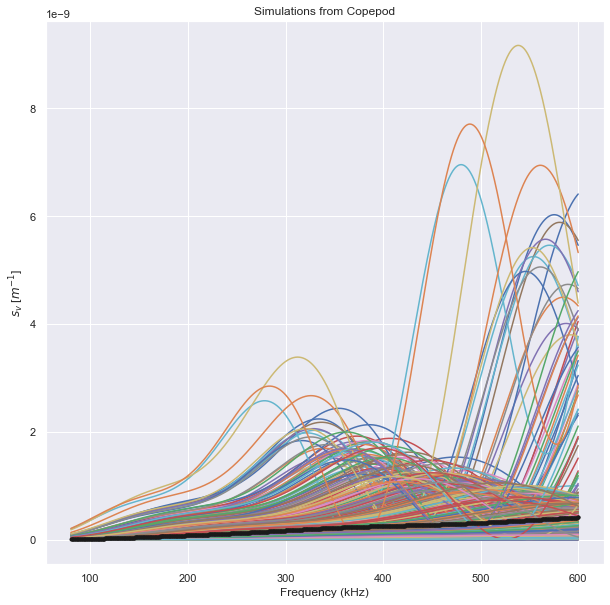

In [42]:
fig=plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.plot(freqs,sig_bs_sim[:,:,0], freqs, sig_mean[:,0], '.k')
plt.title('Simulations from %s' %(specs[0]))

plt.xlabel('Frequency (kHz)')
plt.ylabel('$s_{v}$ [$m^{-1}$]');

Text(0, 0.5, 'sv [$m^{-1}$]')

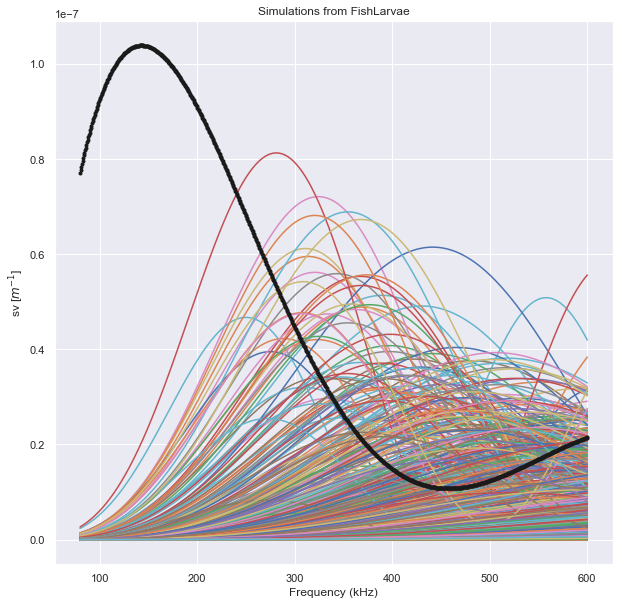

In [41]:
fig=plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.plot(freqs,sig_bs_sim[:,:,6], freqs, sig_mean[:,6], '.k')
plt.title('Simulations from %s' %(specs[6]))

plt.xlabel('Frequency (kHz)')
plt.ylabel('sv [$m^{-1}$]')

In [38]:
cod_index = np.where(specs=='FishLarvae')
cod_scat = pd.read_csv('CODlarvae.txt', header=None, delimiter=' ', names=['frequency', 'TS'], skiprows=1)
cod_sigbs_ve = 10**(cod_scat['TS']/10)
freqs_ve = cod_scat['frequency']/1000

#resample frequency
f = UnivariateSpline(freqs_ve,cod_sigbs_ve, k=5)
sig_mean[:,cod_index[0][0]] = f(freqs)

In [32]:
np.shape(sig_mean[:,cod_index[0][0]])

(801,)

In [31]:
np.shape(f(freqs[:]))

(801,)